# Erdos-Renyiのランダムネットワーク
Erdos-Renyiのランダムネットワークを生成して，基本的なネットワーク指標を計算します。

networkxの読み込み


In [1]:
import networkx as nx

その他ライブラリ

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from scipy.special import comb
import scipy.sparse.csgraph as csgraph

平均最短経路長を計算する関数（networkxのは遅いので）

In [3]:
def compute_distances(g, unweighted=False):
  adj_matrix = nx.adjacency_matrix(g).toarray()
  distances = csgraph.shortest_path(adj_matrix, directed=g.is_directed(), unweighted=unweighted)
  d_ave = np.mean(distances[np.isfinite(distances) & (distances > 0)])
  return d_ave, distances

## Erdos-Renyのランダムネットワークの生成と描画

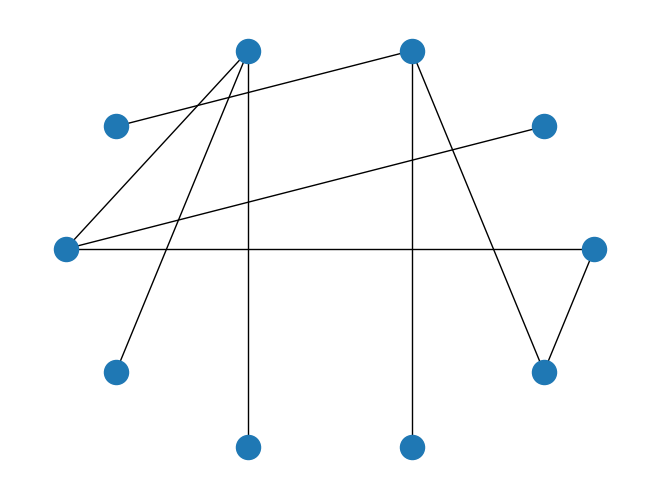

In [4]:
# erdos_renyi_graph(N, p)でランダムグラフを生成
g = nx.erdos_renyi_graph(n=10, p=0.2)
# 描画
nx.draw(g, nx.circular_layout(g))

## 次数分布

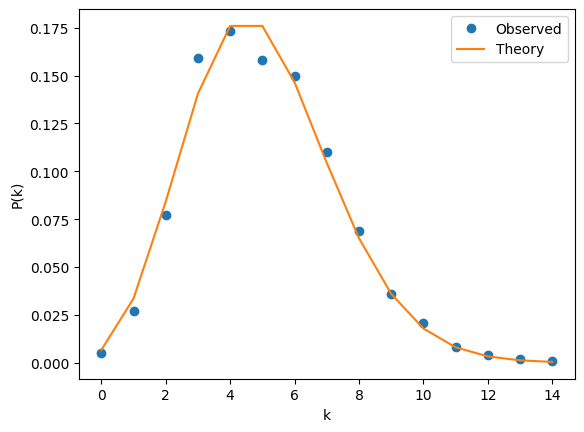

In [5]:
# モデルネットワークの生成
g = nx.erdos_renyi_graph(n=1000, p=0.005)

# 次数分布の計算
degrees = [d for _, d in g.degree()]
max_degree = max(degrees)
k = np.arange(max_degree + 1)

# 次数分布P(k)の計算
degree_count = nx.degree_histogram(g)
degree_dist = np.array(degree_count) / len(g)

# 理論分布の計算（二項分布）
def theoretical_dist(k, N, p):
    return comb(N-1, k) * (p**k) * ((1-p)**(N-1-k))

theory_dist = [theoretical_dist(ki, 1000, 0.005) for ki in k]

# プロット
plt.plot(k, degree_dist, 'o', label='Observed')  # 実測値
plt.plot(k, theory_dist, '-', label='Theory')    # 理論値
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend()

## 平均最短経路長

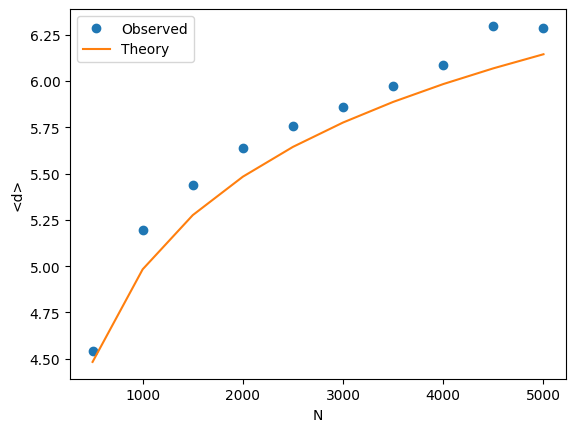

In [6]:
# パラメータ設定
k_ave = 4  # 平均次数
N_seq = np.arange(500, 5500, 500)  # 計算対象のN
d_ave = []  # 平均最短経路長を格納するリスト

# 各ノード数における平均最短経路長を計算
for N in N_seq:
    # 確率 p = k_ave/(N-1)でネットワークを生成
    g = nx.erdos_renyi_graph(n=N, p=k_ave/(N-1))
    # 平均最短経路長の計算
    d_ave_ind, _ = compute_distances(g)
    d_ave.append(d_ave_ind)

# 理論値の計算：ln(N)/ln(k_ave)
theory_d = np.log(N_seq) / np.log(k_ave)

# プロット
plt.plot(N_seq, d_ave, 'o', label='Observed')  # 実測値
plt.plot(N_seq, theory_d, '-', label='Theory')  # 理論値
plt.xlabel('N')
plt.ylabel('<d>')
plt.legend()

## 平均クラスタ係数

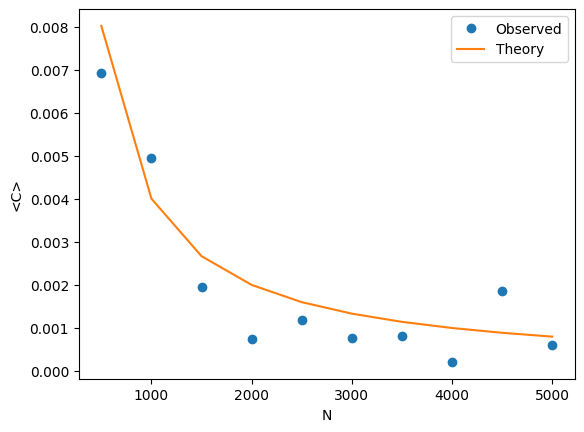

In [7]:
# パラメータ設定
k_ave = 4  # 平均次数
N_seq = np.arange(500, 5500, 500)  # 調査対象のN
C_ave = []  # 平均クラスタ係数を格納するリスト

# 各ノード数における平均クラスタ係数を計算
for N in N_seq:
    # 確率 p = k_ave/(N-1)でネットワークを生成
    g = nx.erdos_renyi_graph(n=N, p=k_ave/(N-1))
    # 平均クラスタ係数の計算
    C_ave.append(nx.average_clustering(g))

# 理論値の計算：k_ave/(N-1)
theory_C = k_ave / (N_seq - 1)

# プロット
plt.plot(N_seq, C_ave, 'o', label='Observed')  # 実測値
plt.plot(N_seq, theory_C, '-', label='Theory')  # 理論値
plt.xlabel('N')
plt.ylabel('<C>')
plt.legend()

## 現実の生物ネットワークと Erdos–Renyi のランダムネットワークの次数分布の比較
大腸菌のタンパク質相互作用ネットワークの読み込み

In [8]:
# エッジリストの読み込み
df = pd.read_csv("https://raw.githubusercontent.com/kztakemoto/network-analysis-in-biology/refs/heads/main/data/ecoli_ppi_Hu_etal_2009.txt", sep='\s+', header=None)

# グラフオブジェクトの作成
g = nx.from_pandas_edgelist(df, source=0, target=1)
g = nx.Graph(g)  # 多重エッジを削除
g.remove_edges_from(nx.selfloop_edges(g))  # 自己ループを削除

# 最大連結成分の取得
lcc = max(nx.connected_components(g), key=len)
g = g.subgraph(lcc)

次数分布の比較

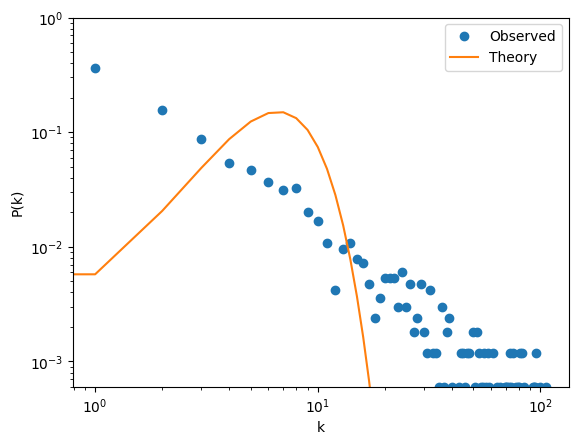

In [9]:
# 次数分布の計算
degrees = [d for _, d in g.degree()]
max_degree = max(degrees)
k = np.arange(max_degree + 1)

# 次数分布P(k)の計算
degree_count = nx.degree_histogram(g)
degree_dist = np.array(degree_count) / len(g)

# 理論分布の計算（二項分布）
N = len(g)
k_ave = np.mean([d for _, d in g.degree()])
theory_dist = [theoretical_dist(ki, N, k_ave/(N-1)) for ki in k]

# プロット
plt.plot(k, degree_dist, 'o', label='Observed')  # 実測値
plt.plot(k, theory_dist, '-', label='Theory')    # 理論値
plt.xlabel('k')
plt.ylabel('P(k)')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1/N, 1)
plt.legend()

## 現実の生物ネットワークと Erdos–Renyi のランダムネットワークの平均最短経路長と平均クラスタ係数の比較

In [11]:
# 調査するネットワークのファイル名リスト
files = [
    "ecoli_regDB5.txt",
    "protein_structure_1A6N_A.txt",
    "protein_structure_1BKS_A.txt",
    "protein_structure_2VIK_A.txt",
    "ecoli_ppi_Hu_etal_2009.txt",
    "yeast_ppi_Batada_etal_2006.txt",
    "human_ppi_hippie_v2.2.txt",
    "metabolic_ecoli.txt",
    "metabolic_yeast.txt",
    "metabolic_human.txt",
    "human_structural_brain_network_Ardesch_2019.txt",
    "human_functional_brain_network_1000_Functional_Connectomes.txt",
    "marine_food_web_pnas_102_15_5443_01562.txt",
    "terrestrial_food_web_caribbean.txt"
]

# データを格納するためのリスト
data = []

for file in files:
    # エッジリストの読み込み
    df = pd.read_csv(f"https://raw.githubusercontent.com/kztakemoto/network-analysis-in-biology/refs/heads/main/data/{file}", sep='\s+', header=None)

    # グラフオブジェクトの作成
    g = nx.from_pandas_edgelist(df, source=0, target=1)
    g = nx.Graph(g)  # 多重エッジを削除
    g.remove_edges_from(nx.selfloop_edges(g))  # 自己ループを削除

    # 最大連結成分の取得
    lcc = max(nx.connected_components(g), key=len)
    g = g.subgraph(lcc)

    # 各指標の計算
    N = g.number_of_nodes()  # ノード数
    k_ave = np.mean([d for _, d in g.degree()])  # 平均次数
    d_ave, _ = compute_distances(g)  # 平均最短経路長
    c_ave = nx.average_clustering(g)  # 平均クラスタ係数

    # データを追加
    data.append({
        'Network': file,
        'N': N,
        '<k>': k_ave,
        'd_ave': d_ave,
        'd_ave_ER': np.log(N) / np.log(k_ave),
        'C_ave': c_ave,
        'C_ave_ER': k_ave / (N-1)
    })

# データフレームの作成と表示
df_results = pd.DataFrame(data)

結果の表示

In [12]:
df_results

,Network,N,<k>,d_ave,d_ave_ER,C_ave,C_ave_ER
0,ecoli_regDB5.txt,1202,4.660566,3.596242,4.607610,0.259694,0.003881
1,protein_structure_1A6N_A.txt,151,9.178808,4.021104,2.263199,0.569764,0.061192
2,protein_structure_1BKS_A.txt,255,10.086275,4.409943,2.397595,0.537606,0.039710
3,protein_structure_2VIK_A.txt,126,9.777778,3.417905,2.121072,0.564999,0.078222
4,ecoli_ppi_Hu_etal_2009.txt,1673,7.106993,4.147419,3.784841,0.081639,0.004251
5,yeast_ppi_Batada_etal_2006.txt,2752,6.611192,4.901739,4.193263,0.286368,0.002403
6,human_ppi_hippie_v2.2.txt,14619,14.217388,3.920735,3.612809,0.117423,0.000973
7,metabolic_ecoli.txt,879,2.616610,8.866386,7.047437,0.060302,0.002980
8,metabolic_yeast.txt,670,2.620896,9.715280,6.753679,0.063138,0.003918
9,metabolic_human.txt,1029,2.532556,13.874029,7.464621,0.065207,0.002464


## やってみよう
* このNotebookを参考にして，別の生物ネットワークを読み込んでErdos-Renyiのランダムネットワークと比較してみよう（``data``に様々ある）。
* Notebookを参考に自分のネットワークデータをErdos-Renyiのランダムネットワークと比較してみよう。